In [ ]:
from google.colab import files

uploaded = files.upload()

Saving fraud_data.csv to fraud_data (2).csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('fraud_data.csv')
print(df.head())

  trans_date_trans_time                          merchant        category  \
0      04-01-2019 00:58  "Stokes, Christiansen and Sipes"     grocery_net   
1      04-01-2019 15:06                      Predovic Inc    shopping_net   
2      04-01-2019 22:37                   Wisozk and Sons        misc_pos   
3      04-01-2019 23:06                    Murray-Smitham     grocery_pos   
4      04-01-2019 23:59                        Friesen Lt  health_fitness   

      amt   city state      lat      long  city_pop  \
0   14.37  Wales    AK  64.7556 -165.6723       145   
1  966.11  Wales    AK  64.7556 -165.6723       145   
2   49.61  Wales    AK  64.7556 -165.6723       145   
3  295.26  Wales    AK  64.7556 -165.6723       145   
4   18.17  Wales    AK  64.7556 -165.6723       145   

                          job         dob                         trans_num  \
0  "Administrator, education"  09-11-1939  a3806e984cec6ac0096d8184c64ad3a1   
1  "Administrator, education"  09-11-1939  a5918

In [ ]:
#Data preprocessing

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

df = pd.read_csv('fraud_data.csv')

# Get numerical features, excluding non-numeric columns
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

# Check for missing values and handle them only for numerical features
for col in numerical_features:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

# Intended numerical features list
intended_numerical_features = ['amt', 'transaction_frequency', 'time_since_last_purchase',
                               'distance_to_merchant', 'amt_deviation', 'transaction_amount_30_days',
                               'account_age']

# Handle missing or non-numeric columns as needed
numerical_features = []
for col in intended_numerical_features:
    if col in df.columns:
        if df[col].dtype in (np.number,):
            numerical_features.append(col)
        else:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                df[col].fillna(df[col].mean(), inplace=True)
                numerical_features.append(col)
            except ValueError:
                print(f"Warning: Could not convert '{col}' to numeric. Excluding from numerical features.")
    else:
        print(f"Warning: Intended numerical feature '{col}' is missing from the dataframe. Imputing with 0.")
        df[col] = 0
        numerical_features.append(col)

# Normalize data (Standard Scaling) for the available numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X = df.drop('fraud', axis=1)
y = df['fraud']

if 'trans_date_trans_time' in X.columns:
    X['trans_date_trans_time'] = pd.to_datetime(X['trans_date_trans_time'], errors='coerce').astype(np.int64) // 10**9

categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_features),
                  ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)])

# Apply preprocessing to the features
X_processed = preprocessor.fit_transform(X)


class_counts = y.value_counts()
print(f"Class distribution before resampling: {class_counts}")

# Apply SMOTE only if the minority class has more than one sample
if class_counts.min() > 1:
    smote = SMOTE(random_state=42, k_neighbors=1)
    X_resampled, y_resampled = smote.fit_resample(X_processed, y)
    print(f"Class distribution after resampling: {y_resampled.value_counts()}")
else:
    print("Warning: Minority class has fewer than 2 samples. SMOTE not applied.")
    X_resampled, y_resampled = X_processed, y

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


<ipython-input-6-104e9afbb18d>:29: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype in (np.number,):


Class distribution before resampling: fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64


In [ ]:
# Feature Engineering

import geopy.distance
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d-%m-%Y %H:%M')

df['last_purchase_time'] = df.groupby('trans_num')['trans_date_trans_time'].shift(1)
df['time_since_last_purchase'] = (df['trans_date_trans_time'] - df['last_purchase_time']).dt.total_seconds()
df['time_since_last_purchase'].fillna(0, inplace=True)

# Geographic Distance (Distance to Merchant)
def calculate_distance(row):
    user_coords = (row['lat'], row['long'])
    merch_coords = (row['merch_lat'], row['merch_long'])
    return geopy.distance.distance(user_coords, merch_coords).km

df['distance_to_merchant'] = df.apply(calculate_distance, axis=1)

# Transaction Amount Deviation from User Average
avg_transaction_amount = df.groupby('trans_num')['amt'].mean().reset_index()
avg_transaction_amount.columns = ['trans_num', 'avg_transaction_amount']
df = pd.merge(df, avg_transaction_amount, on='trans_num', how='left')
df['amt_deviation'] = df['amt'] - df['avg_transaction_amount']


df['is_weekend'] = df['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

# Transaction Time of Day (Morning, Afternoon, Evening, Night)
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
df['time_of_day'] = pd.cut(df['transaction_hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Account Age (in days)
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')
df['account_age'] = (df['trans_date_trans_time'] - df['dob']).dt.days


df = df.drop(['trans_date_trans_time', 'trans_num', 'dob'], axis=1)

print(df.head())


<ipython-input-9-fd4aa2efeca6>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_since_last_purchase'].fillna(0, inplace=True)


                           merchant        category       amt   city state  \
0  "Stokes, Christiansen and Sipes"     grocery_net -0.475741  Wales    AK   
1                      Predovic Inc    shopping_net  3.638209  Wales    AK   
2                   Wisozk and Sons        misc_pos -0.323414  Wales    AK   
3                    Murray-Smitham     grocery_pos  0.738422  Wales    AK   
4                        Friesen Lt  health_fitness -0.459315  Wales    AK   

       lat      long  city_pop                         job  merch_lat  ...  \
0  64.7556 -165.6723       145  "Administrator, education"  65.654142  ...   
1  64.7556 -165.6723       145  "Administrator, education"  65.468863  ...   
2  64.7556 -165.6723       145  "Administrator, education"  65.347667  ...   
3  64.7556 -165.6723       145  "Administrator, education"  64.445035  ...   
4  64.7556 -165.6723       145  "Administrator, education"  65.447094  ...   

   time_since_last_purchase distance_to_merchant  amt_deviatio

In [ ]:
#Model training

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)



In [ ]:
# Evaluate the model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("AUC-ROC Score:")
print(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted'))



Classification Report:
                        precision    recall  f1-score   support

                     0       0.97      1.00      0.98      2504
0"2019-01-01 00:00:44"       0.00      0.00      0.00         1
                     1       0.96      0.77      0.86       385

              accuracy                           0.97      2890
             macro avg       0.64      0.59      0.61      2890
          weighted avg       0.96      0.97      0.96      2890

Confusion Matrix:
[[2492    0   12]
 [   1    0    0]
 [  87    0  298]]
AUC-ROC Score:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.901569631547222


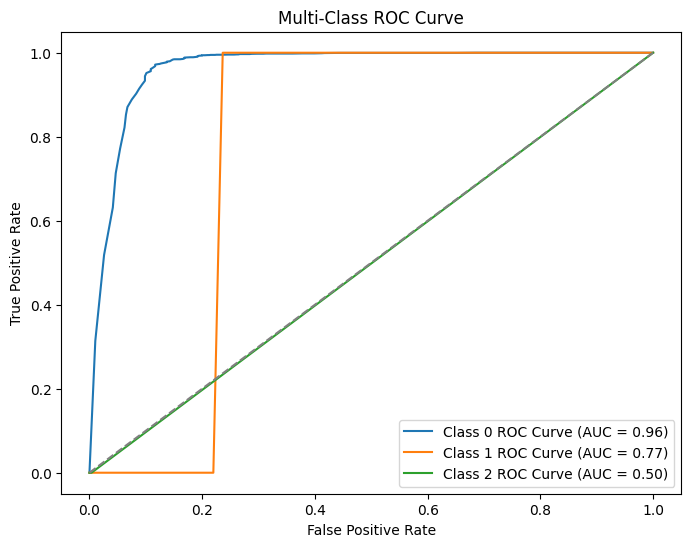

In [ ]:
# ROC curve

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

y_pred_prob = model.predict_proba(X_test)

plt.figure(figsize=(8, 6))

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} ROC Curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


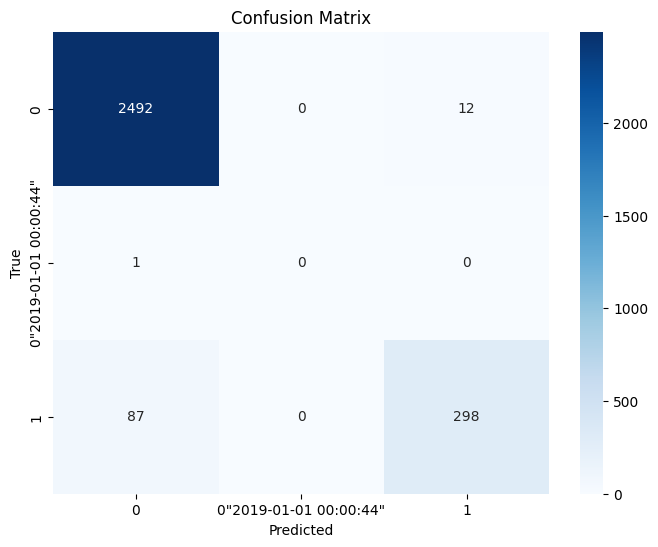

In [ ]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


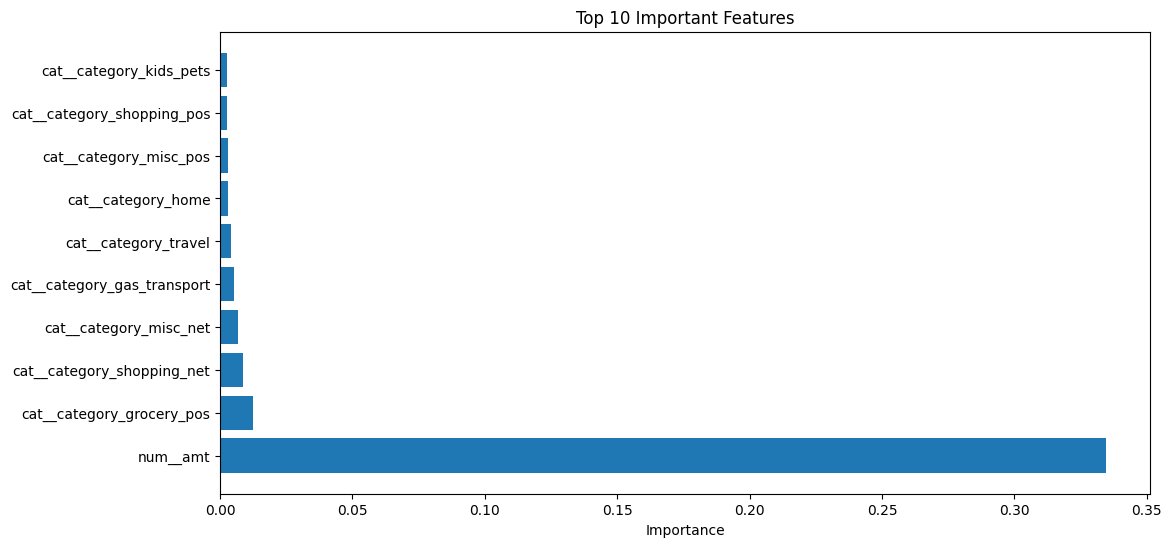

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance from the trained model
importances = model.feature_importances_
indices = importances.argsort()[::-1]

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Plot the top 10 most important features
plt.figure(figsize=(12, 6))
plt.title("Top 10 Important Features")
plt.barh(range(10), importances[indices[:10]], align="center")
plt.yticks(range(10), [feature_names[i] for i in indices[:10]])  # Use feature_names instead of X_train.columns
plt.xlabel("Importance")
plt.show()

In [ ]:
import joblib

joblib.dump(model, 'fraud_detection_model.pkl')


['fraud_detection_model.pkl']

In [ ]:
from google.colab import files

files.download('fraud_detection_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>